# mbo_utilities: User Guide

Converting raw scanimage-tiff files into fused z-planes.

There are two computational efforts made during extraction:

- Scan-phase correction (fix_phase=True)
- Axial alignment / registration (z_register=True)
- (Optional) Image fusion/stitching

![](../docs/_images/assembly_1.png)

# Quickstart

```python

import mbo_utilities as mbo

scan = mbo.imread(r"path/to/tiffs*")  # glob or list of filepaths

# Save options:
scan.roi = 1            # save just mROI 1
scan.roi = [1, 2]       # save mROI 1 and 2
scan.roi = 0            # save all mROIs separately
scan.roi = None         # stitch/fuse all mROIs
scan.fix_phase = True   # correct bi-dir scan-phase
scan.use_fft = True     # subpixel scan-phase correction

mbo.imwrite(scan, "/path/to/save", planes=[1, 7, 14], ext=".tiff")
# Creates: plane_01.tiff, plane_07.tiff, plane_14.tiff

```

In [1]:
# Imports

from pathlib import Path
import numpy as np

import fastplotlib as fpl
import mbo_utilities as mbo
import matplotlib.pyplot as plt

Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

## Read data: `mbo.imread()`

```{important}

Make sure your `data_path` contains only `.tiff` files for this imaging session. If there are other `.tiff` files, such as from another session or a processed file for this session, those files will be included in the scan and lead to errors.

```

Pass a list of files, or a wildcard string (e.g. "/path/to/files/*" matches all files in that directory) to `mbo.imread()`.

In [5]:
# Show docstring

help(mbo.imread)

Help on function imread in module mbo_utilities.lazy_array:

imread(inputs: 'str | Path | Sequence[str | Path]', **kwargs)
    Lazy load imaging data from supported file types.

    Currently supported file types:
    - .bin: Suite2p binary files (.bin + ops.npy)
    - .tif/.tiff: TIFF files (BigTIFF, OME-TIFF and raw ScanImage TIFFs)
    - .h5: HDF5 files
    - .zarr: Zarr v3

    Parameters
    ----------
    inputs : str, Path, ndarray, MboRawArray, or sequence of str/Path
        Input source. Can be:
        - Path to a file or directory
        - List/tuple of file paths
        - An existing lazy array
    **kwargs
        Extra keyword arguments passed to specific array readers.

    Returns
    -------
    array_like
        One of Suite2pArray, TiffArray, MboRawArray, MBOTiffArray, H5Array,
        or the input ndarray.

    Examples
    -------
    >>> from mbo_utilities import imread
    >>> arr = imread("/data/raw")  # directory with supported files, for full filename



In [6]:
# mbo.get_files for getting a list of tiffs
# also can use: list(raw_scanimage_tiffs.glob("*.tif*"))

raw_scanimage_tiffs = mbo.get_files(Path(r"\\rbo-s1\S1_DATA\lbm\demo_user\raw_scanimage_tiffs"))
len(raw_scanimage_tiffs)

50

In [7]:
scan = mbo.imread(raw_scanimage_tiffs)

Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Shape (T, Z, Y, X): {scan.shape}')

Planes: 14
Frames: 5632
ROIs: 2
Shape (T, Z, Y, X): (5632, 14, 448, 448)


## Accessing metadata

`mbo.imread` automatically collects all available metadata in the file. 

This metadata reflects information on all the options selected and otherwise available in ScanImage, for an image acquisition, as well as specific parameters that pertain to the current parameter set e.g. number of rois, number of frames, scan-phase correction properties, etc.

There is a **lot** of ScanImage metadata, even after cleaning empty values.

To view metadata, it's helpful to use [pprint](https://docs.python.org/3/library/pprint.html) so that the scanimage metadata doesn't flood the terminal.

In [9]:
from pprint import pprint

# "si" contains nested scanimage metadata
pprint(scan.metadata, depth=1)

{'border': 3,
 'dtype': 'int16',
 'file_paths': [...],
 'fix_phase': True,
 'fov': [...],
 'fov_px': [...],
 'frame_rate': 17.06701142272251,
 'frames_per_file': [...],
 'max_offset': 4,
 'ndim': 2,
 'num_files': 50,
 'num_fly_to_lines': 16,
 'num_frames': 5632,
 'num_planes': 14,
 'num_rois': 2,
 'objective_resolution': 61,
 'offset': 0.0,
 'page_height': 912,
 'page_width': 224,
 'phasecorr_method': 'mean',
 'pixel_resolution': [...],
 'roi_groups': [...],
 'roi_heights': [...],
 'si': {...},
 'size': 204288,
 'uniform_sampling': 1,
 'upsample': 5,
 'use_fft': False,
 'zoom_factor': 2}


## Accessing image data

Numpy-like indexing:

```python
frame = scan[0, 0, :, :]   # first frame, plane 1
zplane7 = scan[:, 6, :, :] # all frames from z-plane 7
```

RFBOutputContext()

JupyterRenderCanvas(css_height='1200.0px', css_width='1000.0px')
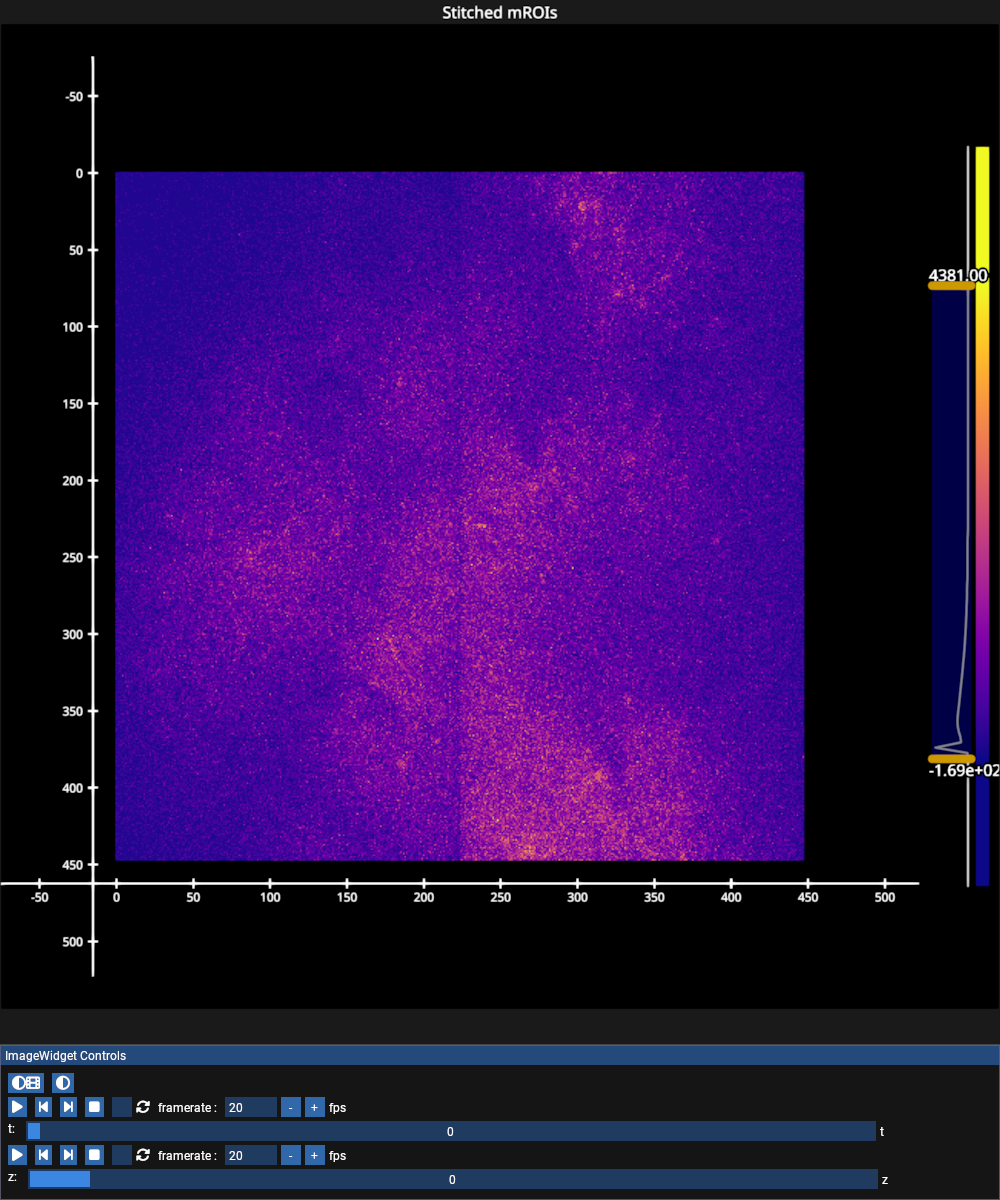

In [8]:
# !! Jupyter Only
iw = scan.imshow()
iw.show()

In [9]:
iw.close()

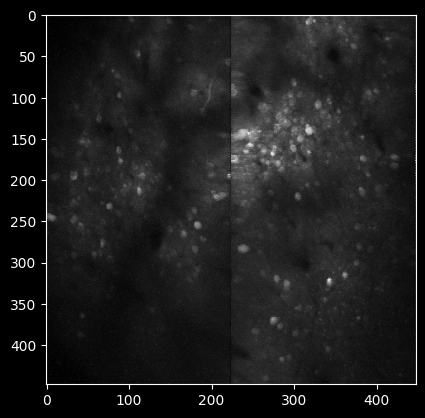

In [7]:
# max-projection: every other frame (2x temporal downsampling)

scan.roi = None
plt.imshow(scan[::2, 7, :, :].max(axis=0), cmap='gray')

### Scan-Phase Correction

![](../docs/_images/corr_nocorr_phase_example.png)

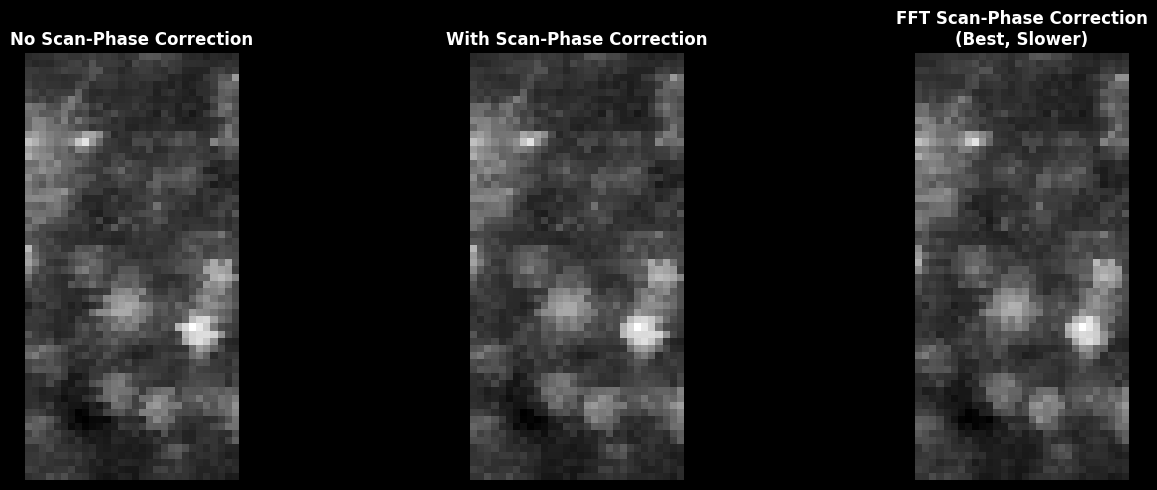

In [ ]:
scan.roi = None
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

scan.fix_phase = False
img_no_corr = scan[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[0].imshow(img_no_corr, cmap='gray')
axes[0].set_title('No Scan-Phase Correction', fontsize=12, fontweight='bold')
axes[0].axis('off')

scan.fix_phase = True
scan.use_fft = False
img_corr = scan[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[1].imshow(img_corr, cmap='gray')
axes[1].set_title('With Scan-Phase Correction', fontsize=12, fontweight='bold')
axes[1].axis('off')

scan.fix_phase = True
scan.use_fft = True
img_fft = scan[:,7,:,:].max(axis=0)[130:190, 250:280]
axes[2].imshow(img_fft, cmap='gray')
axes[2].set_title('FFT Scan-Phase Correction\n(Best, Slower)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# clear out these large arrays in memory
del img_no_corr, img_corr, img_fft

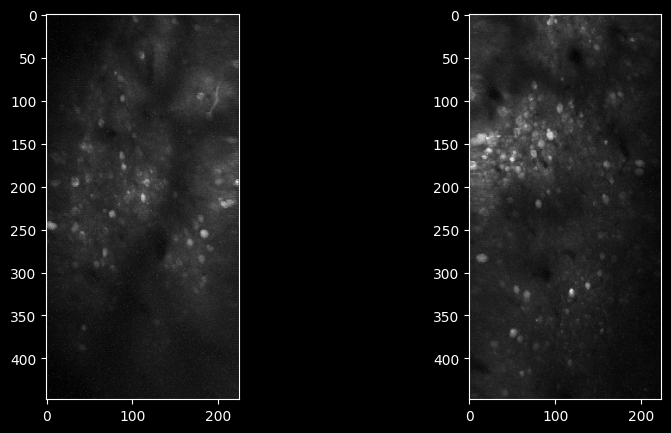

In [30]:
# returns a tuple of all rois
scan.roi = 0
mroi1, mroi2 = scan[:,7,:,:]

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(mroi1.max(axis=0), cmap='gray')
ax[1].imshow(mroi2.max(axis=0), cmap='gray')

In [9]:
from mbo_utilities import SUPPORTED_FTYPES
print(SUPPORTED_FTYPES)

('.npy', '.tif', '.tiff', '.bin', '.h5', '.zarr', '.json')


### Axial (Z) Registration

Light-beads-microscopy data aquisition typically results in each z-plane having a shift relative to the previous z-plane in space.

This can be corrected for automatically by setting `register_z=True`.

**Note**: No matter how many z-planes you are extracting, axial registration computes shifts based on all z-planes in the image data.

Suite3d takes a subset of input tiffs and creates a `s3d_preprocessed` directory that stores the planar shifts and several intermediates.

```python
Loaded file into shared memory in 2.38 sec
    Workers completed in 1.50 sec
    Total time: 3.88 sec
```

This process is completely independant from `mbo.imwrite`. During writing, these planar shifts are loaded and applied to the seleted z-planes.

In [11]:
save_path = Path(r"D:\demo\local_nvme")

In [12]:
scan.roi = None       # Stitch all ROIs together (default behavior)
scan.fix_phase = True
scan.use_fft = True

mbo.imwrite(
    scan,
    save_path,
    ext='.bin',
    num_frames=1550,
    planes=[6, 7, 8],
    overwrite=True,
    register_z=True,  # suite3d axial registration
    metadata={"notes": "No behavior"},
)
# Creates: plane01_stitched/data_raw.bin, plane02_stitched/data_raw.bin
# Compatible with LBM-Suite2p-Python

    Loaded file into shared memory in 2.53 sec
    Workers completed in 1.49 sec
    Total time: 4.03 sec


Saving data_raw.bin:   0%|          | 0/30 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/30 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
out_dirs = list(save_path.iterdir())
out_dirs

[WindowsPath('D:/demo/local_nvme/plane06_stitched'),
 WindowsPath('D:/demo/local_nvme/plane07_stitched'),
 WindowsPath('D:/demo/local_nvme/plane08_stitched'),
 WindowsPath('D:/demo/local_nvme/s3d-preprocessed')]

`mbo.imread` can read these outputs

In [8]:
raw_data = mbo.imread(out_dirs[0] / "data_raw.bin")
raw_data.shape

(1550, 448, 448)

In [16]:
from pprint import pprint
ops = mbo.load_ops(out_dirs[0] / "ops.npy")
pprint(ops, depth=2)

{'1Preg': False,
 'Lx': 448,
 'Ly': 448,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'apply_shift': True,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'border': 3,
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': '',
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': False,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': True,
 'dtype': 'int16',
 'dx': 2.0,
 'dy': 2.0,
 'fast_disk': [],
 'file_paths': ['\\\\rbo-s1\\S1_DATA\\lbm\\demo_user\\raw_scanimage_tiffs\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
                '\\\\rbo-s1\\S1_DATA\\lbm\\demo_user\\raw_scanimage_tiffs\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
                '\\\\rbo-s1\\S1_DATA\\lbm\\demo_user\\raw_scanimage_tiffs\\mk301_03_01_2025_2roi_17p07h

In [17]:
from pprint import pprint # just encase we didnt run the above cell import
z_reg_dir = save_path / "s3d-preprocessed" / "summary"
reg_files = list(z_reg_dir.iterdir())
pprint(reg_files)

[WindowsPath('D:/demo/local_nvme/s3d-preprocessed/summary/init_mov.npy'),
 WindowsPath('D:/demo/local_nvme/s3d-preprocessed/summary/params.npy'),
 WindowsPath('D:/demo/local_nvme/s3d-preprocessed/summary/summary.npy')]


In [10]:
init_mov = mbo.imread(reg_files[0])
init_mov.shape

(14, 115, 561, 453)

In [11]:
# z-registration summary files are not read by imread (coming soon)
summary_npy_file = save_path / "s3d-preprocessed" / "summary" / "summary.npy"
summary_data = np.load(summary_npy_file, allow_pickle=True).item()

In [25]:
# Inspect summary.npy file contents

# Get all keys
keys = list(summary_data.keys())
pprint(f"Keys: {keys}")

for key in sorted(keys):
    value = summary_data[key]
    print(f"\n[{key}]")
    print(f"  Type: {type(value).__name__}")

    if isinstance(value, np.ndarray):
        print(f"  Shape: {value.shape}")
        print(f"  Dtype: {value.dtype}")
        print(f"  Size (elements): {value.size}")
        print(f"  Memory: {value.nbytes / 1024:.2f} KB")
        if value.size > 0 and value.dtype.kind in ['i', 'f', 'u']:  # Only numeric types
            print(f"  Min/Max: {value.min():.3f} / {value.max():.3f}")
        elif value.size > 0 and value.dtype == object:
            print(f"  First item: {value.flat[0]}")
    elif isinstance(value, dict):
        print(f"  Dict keys: {list(value.keys())}")
        print(f"  Num items: {len(value)}")
    elif isinstance(value, list):
        print(f"  List length: {len(value)}")
        if len(value) > 0:
            print(f"  First item type: {type(value[0])}")
            if isinstance(value[0], np.ndarray):
                print(f"  First item shape: {value[0].shape}")
    elif isinstance(value, (int, float)):
        print(f"  Value: {value}")
    elif value is None:
        print(f"  Value: None")
    else:
        print(f"  Value: {str(value)[:100]}")

descriptions = {
    'ref_img_3d': 'Reference image (crosstalk-subtracted, padded, plane-shifted)',
    'ref_img_3d_unaligned': 'Reference image (crosstalk-subtracted, padded, NO plane alignment) - 2D reg only',
    'raw_img': 'Raw mean image directly from TIFF files (shape: Z, Y, X)',
    'img': 'Mean image after crosstalk subtraction (shape: Z, Y, X)',
    'crosstalk_coeff': 'Estimated crosstalk coefficient (scalar)',
    'crosstalk_planes': 'Planes used for crosstalk estimation',
    'crosstalk_info': 'Dictionary of crosstalk data for each test crosstalk and plane',
    'plane_shifts': 'Translation vectors for plane alignment (Z, Y, X)',
    'plane_shifts_uncorrected': 'Uncorrected plane shifts - 2D reg only',
    'refs_and_masks': 'Reference images and masks for registration',
    'reference_params': 'Dictionary of registration parameters used',
    'reference_info': 'Additional registration info - 3D reg only',
    'min_pix_vals': 'Minimum pixel values per plane (for enforcing positivity)',
    'fuse_shifts': 'Estimated shifts for fusing image strips',
    'fuse_shift': 'Median fuse shift used (scalar)',
    'fuse_ccs': 'Cross-correlations for fuse shift estimation',
    'tiffile_xs': 'X-coordinates of ROI start pixels from original TIFFs',
    'xpad': 'X-axis padding size',
    'ypad': 'Y-axis padding size',
    'new_xs': 'New X-coordinates after fusing',
    'og_xs': 'Original X-coordinates',
    'init_mov_path': 'Path to saved initial movie (init_mov.npy)',
    'init_tifs': 'List of initial TIFF files used',
}

for key in sorted(keys):
    if key in descriptions:
        print(f"\n{key}:")
        print(f"  {descriptions[key]}")

# Show whether this is 3D or 2D registration
print("\n **Registration Type**")
if 'reference_info' in keys:
    print("3D Registration was used")
elif 'ref_img_3d_unaligned' in keys:
    print("2D Registration was used")
else:
    print("Unable to determine registration type")

# Show image dimensions
print("\nIMAGE DIMENSIONS\n")
if 'raw_img' in summary_data:
    nz, ny, nx = summary_data['raw_img'].shape
    print(f"Original movie: {nz} planes × {ny} × {nx} pixels")
if 'ref_img_3d' in summary_data:
    ref_shape = summary_data['ref_img_3d'].shape
    print(f"Reference image: {ref_shape}")
if 'xpad' in summary_data and 'ypad' in summary_data:
    print(f"Padding applied: X={summary_data['xpad']}, Y={summary_data['ypad']}")

("Keys: ['ref_img_3d', 'raw_img', 'img', 'crosstalk_coeff', "
 "'crosstalk_planes', 'crosstalk_info', 'plane_shifts', 'refs_and_masks', "
 "'reference_params', 'reference_info', 'min_pix_vals', 'fuse_shifts', "
 "'fuse_shift', 'fuse_ccs', 'tiffile_xs', 'xpad', 'ypad', 'new_xs', 'og_xs', "
 "'init_mov_path', 'init_tifs']")

[crosstalk_coeff]
  Type: NoneType
  Value: None

[crosstalk_info]
  Type: NoneType
  Value: None

[crosstalk_planes]
  Type: NoneType
  Value: None

[fuse_ccs]
  Type: NoneType
  Value: None

[fuse_shift]
  Type: int
  Value: 0

[fuse_shifts]
  Type: NoneType
  Value: None

[img]
  Type: ndarray
  Shape: (14, 449, 449)
  Dtype: float64
  Size (elements): 2822414
  Memory: 22050.11 KB
  Min/Max: -0.904 / 17742.870

[init_mov_path]
  Type: str
  Value: \\rbo-s1\S1_DATA\lbm\demo_user\extracted\s3d-preprocessed\summary\init_mov.npy

[init_tifs]
  Type: ndarray
  Shape: (1,)
  Dtype: object
  Size (elements): 1
  Memory: 0.01 KB
  First item: \\rbo-s1\S1_DATA\lbm\demo_us

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

ref_img = summary_data['ref_img_3d']
plane_shifts = summary_data['plane_shifts']
raw_img = summary_data['raw_img']

Z, H, W = ref_img.shape

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Raw
ax_raw = fig.add_subplot(gs[0:2, 0])
im_raw = ax_raw.imshow(raw_img[0], cmap="gray", animated=True)
ax_raw.set_title(f"BEFORE Alignment - Plane 0/{Z-1}", fontsize=12, fontweight='bold', color='red')
ax_raw.axis('off')
cbar_raw = plt.colorbar(im_raw, ax=ax_raw, fraction=0.046, pad=0.04)

# 2. Registered
ax_aligned = fig.add_subplot(gs[0:2, 1])
im_aligned = ax_aligned.imshow(ref_img[0], cmap="gray", animated=True)
ax_aligned.set_title(f"AFTER Alignment - Plane 0/{Z-1}", fontsize=12, fontweight='bold', color='green')
ax_aligned.axis('off')
cbar_aligned = plt.colorbar(im_aligned, ax=ax_aligned, fraction=0.046, pad=0.04)

# 3. Plane shifts
ax_shifts = fig.add_subplot(gs[0, 2])
y_shifts = plane_shifts[:, 0]  # Y shifts
x_shifts = plane_shifts[:, 1]  # X shifts
planes = np.arange(Z)

ax_shifts.plot(planes, y_shifts, 'o-', label='Y shift', linewidth=2, markersize=6)
ax_shifts.plot(planes, x_shifts, 's-', label='X shift', linewidth=2, markersize=6)
ax_shifts.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax_shifts.set_xlabel('Z-plane', fontweight='bold')
ax_shifts.set_ylabel('Shift (pixels)', fontweight='bold')
ax_shifts.set_title('Plane Shifts Applied', fontsize=12, fontweight='bold')
ax_shifts.legend(loc='best')
ax_shifts.grid(True, alpha=0.3)

# 4. Shift magnitude
ax_magnitude = fig.add_subplot(gs[1, 2])
shift_magnitude = np.sqrt(y_shifts**2 + x_shifts**2)
ax_magnitude.bar(planes, shift_magnitude, color='steelblue', alpha=0.7, edgecolor='black')
ax_magnitude.set_xlabel('Z-plane', fontweight='bold')
ax_magnitude.set_ylabel('Total shift (pixels)', fontweight='bold')
ax_magnitude.set_title('Shift Magnitude', fontsize=12, fontweight='bold')
ax_magnitude.grid(True, alpha=0.3, axis='y')

# 5. Max projections
ax_raw_max = fig.add_subplot(gs[2, 0])
raw_max = raw_img.max(axis=0)
im_raw_max = ax_raw_max.imshow(raw_max, cmap='gray')
ax_raw_max.set_title('Before (Max Proj)', fontsize=11, fontweight='bold')
ax_raw_max.axis('off')
plt.colorbar(im_raw_max, ax=ax_raw_max, fraction=0.046, pad=0.04)

ax_ref_max = fig.add_subplot(gs[2, 1])
ref_max = ref_img.max(axis=0)
im_ref_max = ax_ref_max.imshow(ref_max, cmap='gray')
ax_ref_max.set_title('After (Max Proj)', fontsize=11, fontweight='bold')
ax_ref_max.axis('off')
plt.colorbar(im_ref_max, ax=ax_ref_max, fraction=0.046, pad=0.04)

# 7. Statistics box
ax_stats = fig.add_subplot(gs[2, 2])
ax_stats.axis('off')
stats_text = f"""
Registration Statistics

Z-planes: {Z}
Image size: {H} × {W} px

Y shifts:
  Range: [{y_shifts.min():.1f}, {y_shifts.max():.1f}]
  Mean: {y_shifts.mean():.2f} px
  Std: {y_shifts.std():.2f} px

X shifts:
  Range: [{x_shifts.min():.1f}, {x_shifts.max():.1f}]
  Mean: {x_shifts.mean():.2f} px
  Std: {x_shifts.std():.2f} px

Max total shift: {shift_magnitude.max():.2f} px
"""
ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes,
             fontsize=10, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

def update(frame):
    im_raw.set_array(raw_img[frame])
    im_aligned.set_array(ref_img[frame])
    ax_raw.set_title(f"BEFORE Alignment - Plane {frame}/{Z-1}",
                    fontsize=12, fontweight='bold', color='red')
    ax_aligned.set_title(f"AFTER Alignment - Plane {frame}/{Z-1}",
                        fontsize=12, fontweight='bold', color='green')
    return [im_raw, im_aligned]

ani = FuncAnimation(fig, update, frames=Z, interval=200, blit=True)
plt.tight_layout()
plt.close(fig)
HTML(ani.to_jshtml())

In [ ]:
# Option 1: Stitch all ROIs together (default)
scan.roi = None
mbo.imwrite(scan, save_path / "stitched")
# Creates: plane01_stitched.tiff, plane02_stitched.tiff, ...

# Option 2: Save all ROIs as separate files
scan.roi = 0
mbo.imwrite(scan, save_path / "split_rois")
# Creates: plane01_roi1.tiff, plane01_roi2.tiff, ..., plane14_roi1.tiff, plane14_roi2.tiff

# Option 3: Save specific ROI only
scan.roi = 1
mbo.imwrite(scan, save_path / "roi1_only")
# Creates: plane01_roi1.tiff, plane02_roi1.tiff, ..., plane14_roi1.tiff

# Option 4: Save multiple specific ROIs
scan.roi = [1, 3]
mbo.imwrite(scan, save_path / "roi1_and_roi3")
# Creates: plane01_roi1.tiff, plane01_roi3.tiff, ..., plane14_roi1.tiff, plane14_roi3.tiff

## Visualize data with [fastplotlib](https://www.fastplotlib.org/user_guide/guide.html#what-is-fastplotlib) (jupyter only)

To get a rough idea of the quality of your extracted timeseries, we can create a fastplotlib visualization to preview traces of individual pixels.

Here, we simply click on any pixel in the movie, and we get a 2D trace (or "temporal component" as used in this field) of the pixel through the course of the movie:

More advanced visualizations can be easily created, i.e. adding a baseline subtracted element to the trace, or passing the trace through a frequency filter.

In [ ]:
from ipywidgets import VBox

iw_movie = fpl.ImageWidget(raw_data, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(raw_data.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] = iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])

## Whats Next

See [LBM-Suite2p-Python Quickstart](https://github.com/MillerBrainObservatory/LBM-Suite2p-Python/blob/master/demos/notebooks/quickstart.ipynb) for suite2p registration and segmentation.